In [ ]:
#Importo il modulo drive fornito da Colab per interagire con Google Drive.
from google.colab import drive

#Monta Google Drive nella directory locale /content/drive con stato "pulito".
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
global_var = {
    # PARAMETRI DI CARICAMENTO / PREPROCESSING DEI DATI:
    "batch_size": 64,       #Campioni per batch.
    "n_workers": 2,         #Worker del DataLoader per prefetch/parallelo.
    "max_seq_len": 1024,    #Lunghezza massima; testi lunghi verranno troncati, corti paddati con <pad>.

    # PARAMETRI DEL MODELLO (TextCNN):
    "embedding_dim": 128,            #Più dimensione embedding per capacità semantica.
    "cnn_num_filters": 128,          #Numero filtri per finestra convoluzionale.
    "cnn_kernel_sizes": [3, 4, 5],   #Ampiezza kernel: frasi corte (3), medie (4), lunghe (5).
    "mlp_hidden_dim": 128,           #Numero neuroni nel livello MLP (classificatore).
    "output_dim": 2,                 #Classi: 0 = Human, 1 = GenAI.
    "dropout": 0.30,                 #Dropout più alto per ridurre overfitting.

    # PARAMETRI DI TRAINING:
    "learning_rate": 1e-3,           #Learning rate più grande per addestramento veloce.
    "epochs": 20,                    #Numero massimo di epoche (con early stopping).
    "weight_decay": 1e-4,            #Penalità L2 più forte (regolarizzazione).
    "label_smoothing": 0.05,         #Smoothing CE per calibrazione probabilità.

    # VALIDAZIONE / EARLY STOP:
    "val_size": 0.2,                 #Quota di validation sul training set (20%).
    "patience": 5                    #Early stopping: fermarsi se val_loss non migliora per 5 epoche.
}

In [ ]:
# STANDARD LIBRARY:
import os                         #Interazione con il file system.
import math                       #Funzioni matematiche base.
import copy                       #Copie profonde/shallow di oggetti.
import re                         #Espressioni regolari (regex).
import random                     #Generatore di numeri casuali.
from collections import Counter   #Conta frequenze di elementi.

# NUMERICO / TABELLARE:
import numpy as np               #Calcolo numerico vettoriale/matriciale.
import pandas as pd              #Strutture tabellari (DataFrame).

# VISUALIZZAZIONE:
import matplotlib.pyplot as plt  #Grafici base.
import seaborn as sns            #Grafici statistici (es. heatmap).

# PROGRESS BAR:
from tqdm.notebook import tqdm   #Barra di avanzamento elegante per loop.

# PyTorch:
import torch                                              #Tensori, GPU, operazioni autograd.
import torch.nn as nn                                     #Moduli per costruire reti neurali.
import torch.nn.functional as F                           #Funzioni di attivazione, loss, etc.
from torch.utils.data import Dataset, DataLoader, Subset  #Gestione dataset e batching.
from torch.cuda.amp import autocast, GradScaler           #Mixed precision training (accelerazione su GPU).

# SCIKIT-LEARN:
from sklearn.model_selection import train_test_split      #Split training / validation.
from sklearn.metrics import (
    accuracy_score,                             #Accuratezza.
    balanced_accuracy_score,                    #Accuratezza bilanciata per classi sbilanciate.
    f1_score,                                   #F1-score.
    precision_recall_fscore_support,            #Precision, recall, f1 per classe.
    confusion_matrix,                           #Matrice di confusione.
    classification_report                       #Report testuale completo.
)

In [ ]:
#Se hai una GPU NVIDIA disponibile e PyTorch con build CUDA, usa "cuda:0".
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"[LOG] Device → {device}")

[LOG] Device -> cpu


In [ ]:
def collate_trim(batch):
    """
    Collate function personalizzata per NLP con sequenze padded.
    Rimuove il padding tagliando tutte le sequenze del batch alla lunghezza massima effettiva (senza 0).

    Input: lista di tuple (x: [T_max], y: int)
    Output:
      - xs_trim: tensore [B, L_batch] trimmato
      - ys: etichette [B]
    """
    xs, ys = zip(*batch)
    lens = [int((x != 0).sum().item()) for x in xs]                #Lunghezze reali.
    maxlen = max(1, max(lens) if lens else 1)                      #Max lunghezza reale.
    xs_trim = torch.stack([x[:maxlen] for x in xs])                #Troncamento dinamico.
    ys = torch.stack(ys)
    return xs_trim, ys

def make_loader(dataset, batch_size, shuffle):
    """
    Costruisce un DataLoader con:
      - collate_fn = collate_trim (dynamic padding)
      - pin_memory per trasferimenti GPU più rapidi
      - persistent_workers + prefetch_factor (se n_workers > 0)
    """
    kwargs = {}
    if global_var["n_workers"] > 0:
        kwargs["persistent_workers"] = True
        kwargs["prefetch_factor"] = 4                         #Più batch prefetchati per ridurre attese I/O.
    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=global_var["n_workers"],
        pin_memory=(device.type == "cuda"),
        collate_fn=collate_trim,
        **kwargs
    )

In [ ]:
def seed_everything(seed=42):
    #Imposta i seed per avere risultati riproducibili.
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True         #Forza determinismo (meno ottimizzazioni).
    torch.backends.cudnn.benchmark = False            #Disattiva auto-tuning cuDNN.

#Fissiamo il seed di default (42).
seed_everything(42)

# PATH AI FILE CSV ORIGINALI:
TRAIN_CSV_ORIG = "/content/drive/MyDrive/TESI-Classificazione/MIO/it_train_full.csv"
DEV_CSV_ORIG   = "/content/drive/MyDrive/TESI-Classificazione/MIO/it_dev_full.csv"

#Cartella base per salvare i file ridotti/holdout.
BASE = "/content/drive/MyDrive/TESI-Classificazione/MIO"
os.makedirs(BASE, exist_ok=True)

# PATH DEI NUOVI DATASET GENERATI:
TRAIN_REDUCED_CSV = f"{BASE}/it_train_reduced.csv"
DEV_REDUCED_CSV   = f"{BASE}/it_dev_reduced.csv"
EVAL_CSV          = f"{BASE}/it_eval_holdout.csv"

#Caricamento dei dataset originali.
df_train = pd.read_csv(TRAIN_CSV_ORIG)
df_dev   = pd.read_csv(DEV_CSV_ORIG)
assert "label" in df_train and "label" in df_dev    #Controllo che la colonna 'label' esista.

# FUNZIONE DI CAMPIONAMENTO PER CLASSI:
rng = np.random.default_rng(42)
def sample_indices_by_class(df, label_value, k, rng):
    #Prende tutti gli indici con una certa label.
    idx_all = df.index[df["label"] == label_value].to_numpy()
    if idx_all.size == 0: return np.array([], dtype=int)      #Se non ci sono esempi.
    k = int(min(k, idx_all.size))                             #Non campiona più esempi di quanti ne esistono.
    if k == 0: return np.array([], dtype=int)
    return rng.choice(idx_all, size=k, replace=False)         #Campionamento senza rimpiazzo.

# NUMERO DI ESEMPI DA ESTRARRE PER L'HOLDOUT (per classe):
num_eval_per_class_train = {0: 100, 1: 200}     #Dal train.
num_eval_per_class_dev   = {0:  30, 1:  60}     #Dal dev.

# CAMPIONAMENTO EFFETTIVO DEGLI INDICI PER TRAIN/DEV:
train_indices_sel = np.concatenate([
    sample_indices_by_class(df_train, c, k, rng) for c, k in num_eval_per_class_train.items()
]) if len(df_train) else np.array([], dtype=int)

dev_indices_sel = np.concatenate([
    sample_indices_by_class(df_dev, c, k, rng) for c, k in num_eval_per_class_dev.items()
]) if len(df_dev) else np.array([], dtype=int)

# COSTRUZIONE DEL DATASET DI EVAL, CON ANNOTAZIONE DELLA PROVENIENZA:
eval_from_train = df_train.loc[train_indices_sel].copy()
eval_from_dev   = df_dev.loc[dev_indices_sel].copy()
eval_from_train["source_split"] = "train"   #Origine = train.
eval_from_dev["source_split"]   = "dev"     #Origine = dev.

df_eval = pd.concat([eval_from_train, eval_from_dev], ignore_index=True)
df_eval["intended_use"] = "evaluation"      #Flag: destinato alla valutazione.

#RIMOZIONE DAGLI SPLIT ORIGINALI (senza riferimenti a variabili inesistenti):
df_train_reduced = df_train.drop(index=train_indices_sel).reset_index(drop=True)
df_dev_reduced   = df_dev.drop(index=dev_indices_sel).reset_index(drop=True)

# SALVATAGGI:
df_train_reduced.to_csv(TRAIN_REDUCED_CSV, index=False)
df_dev_reduced.to_csv(DEV_REDUCED_CSV, index=False)
df_eval.to_csv(EVAL_CSV, index=False)

# LOG INFORMATIVI (mostra quante righe per classe sono state effettivamente estratte):
def counts_str(df, name):
    #Conta esempi per label in un dataframe.
    vc = df["label"].value_counts().sort_index()
    return f"{name}: " + "  ".join([f"label={k}:{int(v)}" for k, v in vc.items()])

#Stampa riepilogo.
print(f"[LOG] Holdout creato: eval={len(df_eval)} "
      f"({len(eval_from_train)} da train, {len(eval_from_dev)} da dev).")
print("[LOG] Composizione EVAL -->", counts_str(df_eval, "eval"))
print("[LOG] Nuove dimensioni --> train:", len(df_train_reduced), "| dev:", len(df_dev_reduced))
print("[LOG] Residui TRAIN -->", counts_str(df_train_reduced, "train_reduced"))
print("[LOG] Residui DEV   -->", counts_str(df_dev_reduced, "dev_reduced"))

# AVVISO ESPLICITO SE LO SPLIT E' MONO-CLASSE:
if df_eval["label"].nunique() == 1:
    print("[WARN] EVAL è mono-classe.")

[LOG] Holdout creato: eval=260 (200 da train, 60 da dev).
[LOG] Composizione EVAL --> eval: label=1:260
[LOG] Nuove dimensioni --> train: 3974 | dev: 1783
[LOG] Residui TRAIN --> train_reduced: label=1:3974
[LOG] Residui DEV   --> dev_reduced: label=1:1783
[WARN] EVAL è mono-classe.


In [ ]:
PAD, UNK = "<pad>", "<unk>"                              #Special token: padding e unknown.
_token_re = re.compile(r"\b\w+\b", flags=re.UNICODE)     #Regex per parole (unicode): confini di parola + \w.

def basic_tokenizer(text: str):
    return _token_re.findall(str(text).lower())          #Lowercase + estrazione token con regex.

def build_vocab(text_iter, min_freq: int = 1):
    counter = Counter()                                  #Conta frequenze dei token.
    for line in text_iter:
        counter.update(basic_tokenizer(line))            #Aggiorna frequenze scorrendo i testi.
    vocab = {PAD: 0, UNK: 1}                             #Indici riservati: 0 per PAD, 1 per UNK.
    for tok, c in counter.most_common():                 #Inserimento per ordine di frequenza.
        if c >= min_freq:                                #Soglia minima di frequenza.
            vocab[tok] = len(vocab)                      #ID progressivo assegnato al token.
    return vocab

class TextDataset(Dataset):
    def __init__(self, csv_path: str, vocab: dict | None = None):
        df = pd.read_csv(csv_path)                        #Carica CSV con colonne: text, label.
        self.texts  = df["text"].astype(str).tolist()     #Lista testi (str).
        self.labels = df["label"].astype(int).tolist()    #Lista etichette (int).
        self.vocab  = vocab or build_vocab(self.texts)    #Riusa vocab se dato, altrimenti costruiscilo.

    def __len__(self):
        return len(self.labels)                           #Numero di esempi nel dataset.

    def encode(self, text: str):
        #Token --> ID (UNK se non presente nel vocabolario).
        ids = [self.vocab.get(t, self.vocab[UNK]) for t in basic_tokenizer(text)]
        #Troncamento alla lunghezza massima consentita.
        ids = ids[: global_var["max_seq_len"]]
        #Padding a destra fino a max_seq_len.
        ids += [self.vocab[PAD]] * (global_var["max_seq_len"] - len(ids))
        return torch.tensor(ids, dtype=torch.long)        #Tensore di indici (Long).

    def __getitem__(self, idx):
        #Restituisce: (sequenza indicizzata, label) come tensori.
        return self.encode(self.texts[idx]), torch.tensor(self.labels[idx], dtype=torch.long)

In [ ]:
# PATH DEI DATASET (creati nel blocco HOLDOUT):
TRAIN_CSV = TRAIN_REDUCED_CSV
TEST_CSV  = DEV_REDUCED_CSV

# 1) COSTRUZIONE VOCABOLARIO SOLO SUL TRAIN COMPLETO:
full_train = TextDataset(TRAIN_CSV)             #Carica testo/label e (se non fornito) costruisce il vocab.
vocab = full_train.vocab                        #Estrae il vocabolario costruito dal train.
print(f"[LOG] Vocabulary size: {len(vocab)}")   #Log diagnostico della dimensione del vocab.

# 2) SPLIT STRATIFICATO train/val (il test resta chiuso):
labels = np.array(full_train.labels)            #Array numpy delle etichette per stratificazione.
idx = np.arange(len(full_train))                #Indici 0..N-1 degli esempi del train.

tr_idx, val_idx = train_test_split(             #Split con proporzione val = global_var["val_size"].
    idx,
    test_size=global_var["val_size"],
    random_state=42,                            #Seme fisso per uno split riproducibile.
    stratify=labels                             #Mantiene le proporzioni di classe su train e val.
)

#Sottoinsiemi del dataset di train: condividono la stessa istanza (stesso vocab).
train_dataset = Subset(full_train, tr_idx)
val_dataset   = Subset(full_train, val_idx)

#Test reale caricato da file separato ma forzato ad usare lo stesso vocabolario del train.
test_dataset  = TextDataset(TEST_CSV, vocab=vocab)

# 3) DATALOADER CON DYNAMIC PADDING (collate_trim):
train_loader = make_loader(train_dataset, global_var["batch_size"], shuffle=True)
val_loader   = make_loader(val_dataset,   global_var["batch_size"], shuffle=False)
test_loader  = make_loader(test_dataset,  global_var["batch_size"], shuffle=False)

[LOG] Vocabulary size: 44372


In [ ]:
# MODELLO (TexyCNN):
class TextCNN(nn.Module):
    def __init__(self,
                 vocab_size: int,
                 emb_dim: int,
                 num_filters: int,
                 kernel_sizes: list[int],
                 mlp_hidden_dim: int,
                 num_classes: int,
                 dropout: float = 0.5,
                 padding_idx: int = 0):
        super().__init__()
        #Lookup embedding: da ID token --> vettori continui.
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=padding_idx)
        #Convoluzioni 1D con kernel multipli (es. 3,4,5).
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=emb_dim, out_channels=num_filters, kernel_size=k)
            for k in kernel_sizes
        ])

        #Dimensione complessiva dopo concat dei filtri.
        conv_out = num_filters * len(kernel_sizes)
        #Primo layer fully connected (su feature concatenate).
        self.fc1 = nn.Linear(conv_out, mlp_hidden_dim)
        #Ultimo layer per proiettare a K classi.
        self.fc2 = nn.Linear(mlp_hidden_dim, num_classes)
        #Dropout per regolarizzazione.
        self.drop = nn.Dropout(dropout)
        #Attivazione ReLU.
        self.act  = nn.ReLU()

    def forward(self, x):
        #Input: [B,T] con token IDs.
        emb = self.embedding(x)        #[B,T,E] --> embedding.
        emb = emb.transpose(1, 2)      #[B,E,T] --> richiesto da Conv1d.

        pooled = []
        for conv in self.convs:
            h = self.act(conv(emb))     #[B,F,T’] feature map dopo conv.
            p = torch.amax(h, dim=2)    #Global max pooling --> [B,F].
            pooled.append(p)

        #Concatenazione dei vettori pooled (tutte le kernel size).
        feat = torch.cat(pooled, dim=1)     #[B, F * n_kernels].
        #MLP: FC1 --> ReLU --> Dropout --> FC2.
        h = self.drop(self.act(self.fc1(feat)))
        h = self.drop(h)

        return self.fc2(h)              #Logits finali [B,K].


# LOSS (class-weights se sbilanciato):
cnt = Counter(np.array(full_train.labels)[tr_idx])            #Conta esempi per classe sul TRAIN.
tot = sum(cnt.values())                                       #Totale esempi.
imbalance = abs(cnt.get(0,0) - cnt.get(1,0)) / max(1, tot)    #Sbilanciamento relativo.

if imbalance < 0.05:
    print("[LOG] Dataset bilanciato → niente class weights")
    #CrossEntropy standard con label smoothing.
    loss_fn = nn.CrossEntropyLoss(label_smoothing=global_var["label_smoothing"])
else:
    print("[LOG] Dataset sbilanciato → uso class weights")
    #Calcolo pesi inversi alla frequenza.
    w = torch.tensor([tot/max(1,cnt.get(0,1)), tot/max(1,cnt.get(1,1))], dtype=torch.float, device=device)
    #CrossEntropy pesata + label smoothing.
    loss_fn = nn.CrossEntropyLoss(weight=w, label_smoothing=global_var["label_smoothing"])


# ISTANZAZIONE DEL MODELLO, OPTIMAZER E SCHEDULER:
model = TextCNN(
    vocab_size=len(vocab),
    emb_dim=global_var["embedding_dim"],
    num_filters=global_var["cnn_num_filters"],
    kernel_sizes=global_var["cnn_kernel_sizes"],
    mlp_hidden_dim=global_var["mlp_hidden_dim"],
    num_classes=global_var["output_dim"],
    dropout=global_var["dropout"],
    padding_idx=0
).to(device)

#Ottimizzatore Adam con weight decay (penalità L2).
optimizer = torch.optim.Adam(model.parameters(), lr=global_var["learning_rate"],weight_decay=global_var["weight_decay"])

#Scheduler (riduce LR quando val_loss smette di migliorare).
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=2)


# LOOP DI TRAINING (mixed precision + early stopping):
def train_amp(model, train_loader, val_loader, epochs, patience=5):
    #GradScaler per mixed precision (solo se GPU CUDA disponibile).
    scaler = torch.amp.GradScaler('cuda', enabled=(device.type=="cuda"))
    history = {"train": [], "val": []}
    best_val, best_state, bad = math.inf, None, 0

    #Prova a compilare il modello (se disponibile torch.compile).
    try:
        if hasattr(torch, "compile"):
            model = torch.compile(model)
    except Exception:
        pass

    for ep in range(epochs):
        model.train()
        running = 0.0
        pbar = tqdm(train_loader, unit="batch", desc=f"Epoch {ep+1}/{epochs} [train]")

        for bx, by in pbar:
            #Spostamento su device (con non_blocking=True per efficienza).
            bx = bx.to(device, non_blocking=True); by = by.to(device, non_blocking=True)
            optimizer.zero_grad(set_to_none=True)
            #Mixed precision autocast.
            with torch.amp.autocast('cuda', enabled=(device.type=="cuda")):
                logits = model(bx)
                loss = loss_fn(logits, by)
            #Backprop con grad scaler.
            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)     #Gradient clipping.
            scaler.step(optimizer); scaler.update()

            running += loss.item()
            pbar.set_postfix(loss=running/(pbar.n+1))

        # VALIDAZIONE:
        model.eval()
        val_loss = 0.0
        with torch.inference_mode(), torch.amp.autocast('cuda', enabled=(device.type=="cuda")):
            for bx, by in val_loader:
                bx = bx.to(device, non_blocking=True); by = by.to(device, non_blocking=True)
                val_loss += loss_fn(model(bx), by).item()

        val_loss /= max(1, len(val_loader))
        history["train"].append(running/max(1, len(train_loader)))
        history["val"].append(val_loss)

        print(f"[LOG] Ep{ep+1}: train={history['train'][-1]:.6f} | val={val_loss:.6f}")

        #Aggiornamento scheduler.
        scheduler.step(val_loss)

        #Early stopping: salva best model e interrompe se non vi è nessun miglioramento.
        if val_loss < best_val - 1e-4:
            best_val, best_state, bad = val_loss, copy.deepcopy(model.state_dict()), 0
        else:
            bad += 1
            if bad >= patience:
                print(f"[LOG] Early stop a epoca {ep+1} (best val={best_val:.6f})."); break

    #Ripristina i pesi del best model.
    if best_state is not None:
        model.load_state_dict(best_state)

    return history


# AVVIO TRAINING CON AMP + early stopping:
history = train_amp(
    model,
    train_loader,
    val_loader,
    global_var["epochs"],
    patience=global_var["patience"]
)

[LOG] Dataset sbilanciato → uso class weights


Epoch 1/20 [train]:   0%|          | 0/50 [00:00<?, ?batch/s]

W0828 20:04:32.071000 3754 torch/utils/cpp_extension.py:118] [0/0] No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


[LOG] Ep1: train=6.916677 | val=5.278015


Epoch 2/20 [train]:   0%|          | 0/50 [00:00<?, ?batch/s]

[LOG] Ep2: train=5.538727 | val=5.281728


Epoch 3/20 [train]:   0%|          | 0/50 [00:00<?, ?batch/s]

[LOG] Ep3: train=5.507156 | val=5.285476


Epoch 4/20 [train]:   0%|          | 0/50 [00:00<?, ?batch/s]

[LOG] Ep4: train=5.485107 | val=5.277049


Epoch 5/20 [train]:   0%|          | 0/50 [00:00<?, ?batch/s]

[LOG] Ep5: train=5.491153 | val=5.305955


Epoch 6/20 [train]:   0%|          | 0/50 [00:00<?, ?batch/s]

[LOG] Ep6: train=5.488257 | val=5.274605


Epoch 7/20 [train]:   0%|          | 0/50 [00:00<?, ?batch/s]

[LOG] Ep7: train=5.468384 | val=5.275201


Epoch 8/20 [train]:   0%|          | 0/50 [00:00<?, ?batch/s]

[LOG] Ep8: train=5.461317 | val=5.282614


Epoch 9/20 [train]:   0%|          | 0/50 [00:00<?, ?batch/s]

[LOG] Ep9: train=5.453355 | val=5.297679


Epoch 10/20 [train]:   0%|          | 0/50 [00:00<?, ?batch/s]

[LOG] Ep10: train=5.441385 | val=5.311471


Epoch 11/20 [train]:   0%|          | 0/50 [00:00<?, ?batch/s]

[LOG] Ep11: train=5.437222 | val=5.279377
[LOG] Early stop a epoca 11 (best val=5.274605).


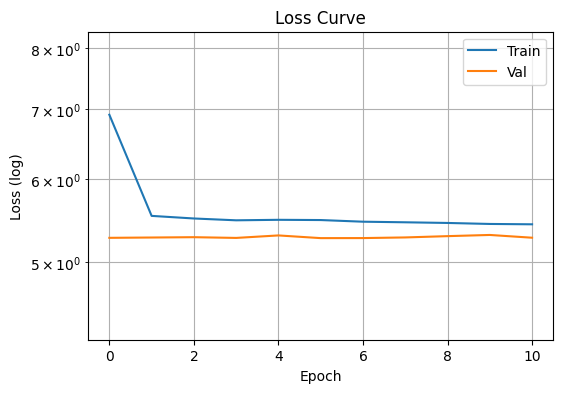

In [ ]:
# === LOSS CURVE (log y) ===
eps = 1e-12
_tr = np.clip(np.asarray(history["train"], dtype=float), eps, None)
_va = np.clip(np.asarray(history["val"],   dtype=float), eps, None)

plt.figure(figsize=(6,4))
plt.plot(_tr, label="Train")
plt.plot(_va, label="Val")
plt.yscale("log")
ymin = min(_tr.min(), _va.min()) * 0.8
ymax = max(_tr.max(), _va.max()) * 1.2
plt.ylim(ymin, ymax)
plt.xlabel("Epoch"); plt.ylabel("Loss (log)"); plt.title("Loss Curve")
plt.legend(); plt.grid(True, which="both"); plt.show()

/usr/local/lib/python3.12/dist-packages/torch/optim/lbfgs.py:457: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  loss = float(closure())


[VAL] temperatura ottima T=9176531.000
[VAL] soglia ottima t*=0.05 (bal_acc=1.000, f1_macro=1.000, acc=1.000)


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use th

[TEST] acc=1.000  prec=1.000  rec=1.000  f1_bin=1.000  f1_macro=1.000  bal_acc=1.000

              precision    recall  f1-score   support

           1      1.000     1.000     1.000      1783

    accuracy                          1.000      1783
   macro avg      1.000     1.000     1.000      1783
weighted avg      1.000     1.000     1.000      1783



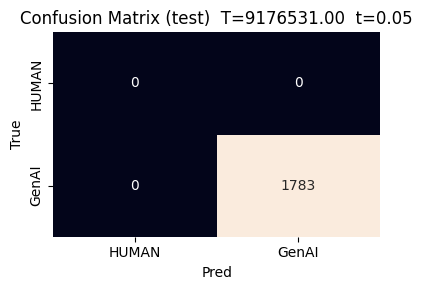

In [ ]:
# 1) CALIBRAZIONE DELLE PROBABILITA' (ottimizza la temperatura T su validation):
def calibrate_temperature(model, val_loader, device):
    model.eval()                                          #Modalità eval: disabilita dropout/batchnorm.
    logits_list, labels_list = [], []                     #Accumulatori per logits e label su tutta la VAL.
    with torch.inference_mode():                          #No grad, mem/compute più leggeri nel loop.
        for bx, by in val_loader:
            logits_list.append(model(bx.to(device)))      #Forward --> logits [B,C].
            labels_list.append(by.to(device))             #Salva etichette corrispondenti [B].
    logits = torch.cat(logits_list)                       #[N,C] tutti i logits di VAL.
    labels = torch.cat(labels_list)                       #[N]   tutte le label di VAL.

    nll = nn.CrossEntropyLoss()                                     #NLL su logits non normalizzati.
    logT = torch.tensor(0.0, device=device, requires_grad=True)     #Param: logT.
    optimizer = torch.optim.LBFGS([logT], lr=0.5, max_iter=50)      #L-BFGS per unidimensionale.

    def closure():
        optimizer.zero_grad()                             #Richiesto da L-BFGS.
        T = torch.exp(logT)                               #Temperatura positiva.
        loss = nll(logits / T, labels)                    #NLL con scaling dei logits.
        loss.backward()                                   #Gradiente rispetto a logT.
        return loss

    optimizer.step(closure)                               #Esegue le iterazioni L-BFGS.
    T = torch.exp(logT).item()                            #Estrae T scalare (float).
    print(f"[VAL] temperatura ottima T={T:.3f}")          #Log del valore trovato.
    return T

# 2) TUNING SOGLIA SU VALIDATION (usando T):
def tune_threshold_on_val(model, val_loader, device, temperature=1.0, metric="balanced_accuracy"):
    model.eval()                                                  #Eval per disattivare dropout/batchnorm.
    y_true_val, y_prob_val = [], []                               #Accumulatori: etichette e p(classe=1).
    with torch.inference_mode():
        for bx, by in val_loader:
            logits = model(bx.to(device)) / temperature             #Applica scaling di temperatura.
            p1 = F.softmax(logits, dim=1)[:, 1].cpu().numpy()       #Probabilità della classe 1.
            y_prob_val.extend(p1); y_true_val.extend(by.numpy())    #Salva per tutta la VAL.
    y_true_val = np.array(y_true_val)
    y_prob_val = np.array(y_prob_val)

    best_t, best_score = 0.5, -1.0                        #Inizializza soglia/score migliori.
    for t in np.linspace(0.05, 0.95, 19):                 #Grid search su 19 soglie in [0.05,0.95].
        y_hat = (y_prob_val >= t).astype(int)             #Predizione binaria a soglia t.

        #Scegli metrica: balanced accuracy (default), oppure macro-F1.
        score = (balanced_accuracy_score(y_true_val, y_hat)
                 if metric == "balanced_accuracy"
                 else f1_score(y_true_val, y_hat, average="macro"))
        if score > best_score:                            #Aggiorna se migliora.
            best_score, best_t = score, t

    #Report finale sulla VAL alla soglia migliore trovata.
    y_hat = (y_prob_val >= best_t).astype(int)
    print(f"[VAL] soglia ottima t*={best_t:.2f} "
          f"(bal_acc={balanced_accuracy_score(y_true_val, y_hat):.3f}, "
          f"f1_macro={f1_score(y_true_val, y_hat, average='macro'):.3f}, "
          f"acc={accuracy_score(y_true_val, y_hat):.3f})")
    return best_t

# 3) VALUTAZIONE SU TEST CON T E SOGLIA TROVATA SU VAL:
def evaluate_on_test_with_threshold(model, test_loader, device, t, temperature=1.0):
    model.eval()                                                  #Eval mode per test.
    y_true, y_prob = [], []                                       #Ground-truth e p(classe=1).
    with torch.inference_mode():
        for bx, by in test_loader:
            logits = model(bx.to(device)) / temperature           #Applica T ottima.
            p1 = F.softmax(logits, dim=1)[:, 1].cpu().numpy()
            y_prob.extend(p1); y_true.extend(by.numpy())
    y_true = np.array(y_true)
    y_pred = (np.array(y_prob) >= t).astype(int)                  #Predizione binaria con soglia t*.

    #Metriche principali.
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", pos_label=1)
    f1m = f1_score(y_true, y_pred, average="macro")
    bal = balanced_accuracy_score(y_true, y_pred)
    print(f"[TEST] acc={acc:.3f}  prec={prec:.3f}  rec={rec:.3f}  f1_bin={f1:.3f}  f1_macro={f1m:.3f}  bal_acc={bal:.3f}\n")
    print(classification_report(y_true, y_pred, digits=3))        #Report per classe e macro/micro avg.

    #Matrice di confusione e heatmap.
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])  # forza 2x2
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cbar=False,
                xticklabels=["HUMAN", "GenAI"],
                yticklabels=["HUMAN", "GenAI"])
    plt.xlabel("Pred"); plt.ylabel("True")
    plt.title(f"Confusion Matrix (test)  T={temperature:.2f}  t={t:.2f}")
    plt.tight_layout(); plt.show()

# ESECUZIONE COMPLETA:
T = calibrate_temperature(model, val_loader, device)                                          #1) Calibra T su VAL.
t_star = tune_threshold_on_val(model, val_loader, device, T, metric="balanced_accuracy")      #2) Trova t* su VAL.
evaluate_on_test_with_threshold(model, test_loader, device, t_star, temperature=T)            #3) Valuta su TEST.

In [ ]:
BASE = "/content/drive/MyDrive/TESI-Classificazione/MIO"        #Percorso base di lavoro su Google Drive.
os.makedirs(BASE, exist_ok=True)                                #Crea la directory se non esiste (idempotente).

#Se non è stato definito val_loader nel notebook, usa il test_loader come validation.
try:
    val_loader                                                 #Prova ad accedere al nome: se non esiste lancia NameError.
except NameError:
    val_loader = test_loader                                   #Fallback sicuro: evita crash nelle funzioni che richiedono VAL.

def extract_vocab(obj):
    """
    Restituisce obj.vocab se esiste; se obj è un Subset o un DataLoader,
    scende ricorsivamente in .dataset finché trova 'vocab'.
    """
    seen = set()                                               #Set di id() per evitare cicli (es. riferimenti ricorsivi).
    while obj is not None and id(obj) not in seen:             #Cammina finché c'è un oggetto nuovo nella catena.
        seen.add(id(obj))                                      #Marca l'oggetto corrente come visitato.
        if hasattr(obj, "vocab"):                              #Caso base: l'oggetto espone direttamente il vocabolario.
            return obj.vocab
        obj = getattr(obj, "dataset", None)                    #Altrimenti scendi in .dataset (Subset/DataLoader/...).
    return None                                                #Se non trovato, segnala fallimento.

#Prova a prendere il vocab da sorgenti note (in ordine di probabilità).
base_vocab = None
for cand in [
    globals().get("train_dataset", None),             #Può essere Subset --> ha .dataset interno.
    globals().get("full_train", None),                #Istanza completa del dataset di train.
    globals().get("train_ds", None),                  #Eventuale alias usato altrove.
    globals().get("train_loader", None),              #DataLoader: si scende in .dataset.
]:
    base_vocab = extract_vocab(cand)                  #Tenta l'estrazione ricorsiva.
    if base_vocab is not None:
        break                                         #Appena trovato, interrompi la ricerca.

#Fallback: usa 'vocab' globale se esiste.
if base_vocab is None and "vocab" in globals():
    base_vocab = vocab                                #Riutilizza il mapping già in memoria.

#Ultimo fallback: ricostruisce dal TRAIN_CSV (non ideale ma funziona)
if base_vocab is None and "TRAIN_CSV" in globals():
    print("[WARN] Non trovo il vocab del training; lo ricostruisco dal TRAIN_CSV (non ideale).")
    base_vocab = TextDataset(TRAIN_CSV).vocab         #Ricostruzione completa.

if base_vocab is None:
    raise RuntimeError(
        "Impossibile recuperare il vocabolario del training. "
        "Assicurati che 'train_dataset' (o 'train_loader') sia in memoria, "
        "oppure definisci una variabile globale 'vocab' con il mapping token→id."
    )

print(f"[LOG] Vocab recuperato correttamente (size={len(base_vocab):,}).")  #Esito positivo con dimensione formattata.

def evaluate_loader(model, loader, label_names=("HUMAN","GenAI"),
                    temperature=1.0, threshold=None, plot_cm=False, title_suffix=""):
    model.eval()                                           #Modalità valutazione: disabilita dropout/batchnorm.
    y_true, y_pred = [], []                                #Accumulatori: etichette vere e predette.

    with torch.inference_mode():                           #No autograd per efficienza/memoria.
        for bx, by in loader:
            #Forward con eventuale temperature scaling (T=1 --> invariato).
            logits = model(bx.to(device)) / temperature

            if threshold is None:
                #Multiclasse standard: predizione = argmax dei logits.
                pred = logits.argmax(1).cpu().numpy()
            else:
                #Binaria con soglia: usa p(classe=1) e confronta con t.
                p1 = F.softmax(logits, dim=1)[:, 1].cpu().numpy()
                pred = (p1 >= threshold).astype(int)

            #Accumula predizioni e label (su CPU/numpy).
            y_pred.extend(pred)
            y_true.extend(by.cpu().numpy())

    # REPORT DETTAGLIATO (dict) CON METRICHE PER CLASSE E MACRO/MICRO/WEIGHTED:
    report = classification_report(
        y_true, y_pred, target_names=list(label_names), output_dict=True, digits=4
    )

    # CONFUSION MATRIX (righe = True, colonne = Pred).
    cm = confusion_matrix(y_true, y_pred)

    if plot_cm:
        #Heatmap della confusion matrix con etichette leggibili.
        plt.figure(figsize=(5, 4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=label_names, yticklabels=label_names)
        ttl = "Confusion Matrix" + (f" {title_suffix}" if title_suffix else "")
        plt.xlabel("Predicted"); plt.ylabel("True"); plt.title(ttl)
        plt.tight_layout(); plt.show()

    return report, cm


def evaluate_csv(model, csv_path, vocab, batch_size=None, n_workers=None,
                 label_names=("HUMAN","GenAI"), temperature=1.0, threshold=None,
                 plot_cm=False, title_suffix=""):
    #Dimensione batch di default dalla config globale.
    batch_size = batch_size or global_var["batch_size"]

    #Costruisce dataset dal CSV riusando il vocabolario del training.
    ds = TextDataset(csv_path, vocab=vocab)

    #DataLoader con dynamic padding via collate_trim (make_loader gestisce n_workers/pin_memory).
    dl = make_loader(ds, batch_size=batch_size, shuffle=False)

    #Valuta come sopra (stesse opzioni di temperature/soglia/plot).
    rep, cm = evaluate_loader(
        model, dl, label_names=label_names,
        temperature=temperature, threshold=threshold,
        plot_cm=plot_cm, title_suffix=title_suffix
    )

    #Restituisce anche la dimensione del dataset per completezza.
    return rep, cm, len(ds)

[LOG] Vocab recuperato (size=44,372).


[LOG] EVAL_HOLDOUT: /content/drive/MyDrive/TESI-Classificazione/MIO/it_eval_holdout.csv (260 righe)
[LOG] Distribuzione label:
label
1    260
[VAL] temperatura ottima T=9176531.000
[VAL] soglia ottima t*=0.05 (bal_acc=1.000, f1_macro=1.000, acc=1.000)


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use th

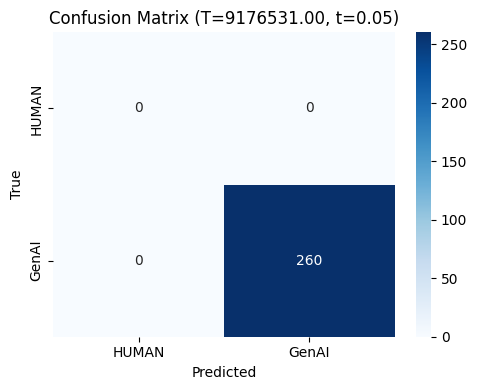


[LOG] Evaluation su holdout — campioni: 260
Accuracy: 1.0000  |  F1 macro: 0.5000  |  Precision macro: 0.5000  |  Recall macro: 0.5000


In [ ]:
EVAL_CSV = f"{BASE}/it_eval_holdout.csv"                        #Path al file CSV di holdout.
df_eval = pd.read_csv(EVAL_CSV)                                 #Caricamento del dataset holdout.
print(f"[LOG] EVAL_HOLDOUT: {EVAL_CSV} ({len(df_eval)} righe)")
print("[LOG] Distribuzione label:"); print(df_eval["label"].value_counts().sort_index().to_string())

#Calibrazione temperatura (temperature scaling sulla validation).
T_eval = calibrate_temperature(model, val_loader, device)

#Scelta soglia decisionale ottimale su validation (es. balanced accuracy).
t_eval = tune_threshold_on_val(model, val_loader, device,temperature=T_eval, metric="balanced_accuracy")

# VALUTAZIONE SU CSV DI HOLDOUT (metriche, confusion matrix e report):
rep_eval, cm_eval, n_eval = evaluate_csv(
    model, EVAL_CSV, vocab=vocab,
    label_names=("HUMAN","GenAI"),
    temperature=T_eval, threshold=t_eval,
    plot_cm=True, title_suffix=f"(T={T_eval:.2f}, t={t_eval:.2f})"
)

#Controllo di consistenza: numero campioni valutati = dimensione holdout.
assert cm_eval.sum() == n_eval, f"Non ho visto tutto l'EVAL: visti {cm_eval.sum()} su {n_eval}"
print(f"\n[LOG] Evaluation su holdout — campioni: {n_eval}")

# STAMPA DELLE METRICHE:
#Caso multi-classe (macro average disponibile).
if 'macro avg' in rep_eval:
    print(f"Accuracy: {rep_eval['accuracy']:.4f}  |  F1 macro: {rep_eval['macro avg']['f1-score']:.4f}  "
          f"|  Precision macro: {rep_eval['macro avg']['precision']:.4f}  |  Recall macro: {rep_eval['macro avg']['recall']:.4f}")
else:
    #Caso mono-classe: gestione separata.
    class_label = list(rep_eval.keys())[0] if rep_eval.keys() else None
    if class_label and isinstance(rep_eval[class_label], dict) and 'f1-score' in rep_eval[class_label]:
         print(f"Accuracy: {rep_eval['accuracy']:.4f}  |  F1 ({class_label}): {rep_eval[class_label]['f1-score']:.4f}  "
              f"|  Precision ({class_label}): {rep_eval[class_label]['precision']:.4f}  |  Recall ({class_label}) {rep_eval[class_label]['recall']:.4f}")
    else:
        #Fallback: se non ci sono altre metriche disponibili.
        print(f"Accuracy: {rep_eval['accuracy']:.4f}")

In [ ]:
#Se BASE non è definito, prova a rilevarlo in due possibili path.
if 'BASE' not in locals():
    for _p in ["/content/drive/MyDrive/TESI-Classificazione/MIO",
               "/content/drive/MyDrive/TEST-Classificazione/MIO"]:
        if os.path.isdir(_p):
            BASE = _p; break

#Path file di holdout.
EVAL_CSV = f"{BASE}/it_eval_holdout.csv"
assert os.path.exists(EVAL_CSV), f"File non trovato: {EVAL_CSV}"

# DATALOADER EVAL RIUSANDO IL VOCAB DEL TRAIN:
eval_ds = TextDataset(EVAL_CSV, vocab=vocab)
eval_dl = DataLoader(
    eval_ds,
    batch_size=global_var["batch_size"],
    num_workers=min(2, global_var["n_workers"]),
    shuffle=False,
    pin_memory=(device.type=="cuda")
)

# INFERENCE CON T_eval E SOGLIA t_eval:
probs, preds = [], []
model.eval()
with torch.inference_mode():
    for bx, _ in eval_dl:
        logits = model(bx.to(device)) / T_eval                #Scaling temperatura.
        p1 = F.softmax(logits, dim=1)[:, 1].cpu().numpy()     #prob classe GenAI.
        probs.extend(p1.tolist())
        preds.extend((p1 >= t_eval).astype(int).tolist())     #Decisione con soglia t_eval.

# COSTRUZIONE DELLA TABELLA DI OUTPUT:
df_src = pd.read_csv(EVAL_CSV)
map_lab = {0: "HUMAN", 1: "GenAI"}
df_out = pd.DataFrame({
    **({ "id": df_src["id"] } if "id" in df_src.columns else {}),             #Mantiene id se presente.
    **({ "topic": df_src["topic"] } if "topic" in df_src.columns else {}),    #Mantiene topic se presente.
    "text": df_src["text"].astype(str),               #Testo originale.
    "true_id": df_src["label"].astype(int),           #Etichetta reale.
    "pred_id": np.array(preds, dtype=int),            #Predizione modello.
    "prob_genai": np.array(probs, dtype=float)        #Probabilità continua GenAI.
})
df_out["true"] = df_out["true_id"].map(map_lab)       #Label reale (stringa).
df_out["pred"] = df_out["pred_id"].map(map_lab)       #Label predetta (stringa).
df_out["correct"] = np.where(df_out["true_id"] == df_out["pred_id"], "✓", "✗")

# FORMATTAZIONE DELLA PROBABILITÀ:
def fmt_prob(x, ndigits=7):
    try:
        s = f"{float(x):.{ndigits}f}"       #Forza numero decimale con ndigits cifre.
    except Exception:
        s = "0.0000000"
    return s.replace(".", ",")              #Sostituisce il punto con la virgola.

df_out["prob_genai_fmt"] = [fmt_prob(v, 7) for v in df_out["prob_genai"].values]

# ORDINAMENTO (prima gli errori, poi i corretti con prob GenAI in ordine decrescente):
df_view = df_out.copy()
df_view["err_rank"] = (df_view["correct"] == "✓").astype(int)
df_view = df_view.sort_values(
    ["err_rank","prob_genai"],
    ascending=[True, False]
).drop(columns=["err_rank"])

# MOSTRA ANTEPRIMA DEI RISULTATI:
pd.set_option("display.max_colwidth", 160)
display_cols = [c for c in ["id","topic"] if c in df_view.columns] \
             + ["text","true","pred","prob_genai_fmt","correct"]
print(f"[INFO] Mostro le prime 30 righe (errori in alto). Il file completo viene salvato su Drive.\n")
display(df_view[display_cols].head(30))

# SALVATAGGIO DEL CSV VERSIONATO CON T E t:
fname = f"eval_predictions_ITA_T{T_eval:.2f}_t{t_eval:.2f}.csv"
save_path = os.path.join(BASE, fname)
#Salva sia float grezzi sia campo formattato.
df_view.to_csv(save_path, index=False, encoding="utf-8")
print("[LOG] File completo salvato in:", save_path)

# SECONDO RIQUADR econdo riquadro: mostra solo gli errori
df_errors = df_view[df_view["correct"]=="✗"][display_cols]
print(f"\n[INFO] Errori totali: {len(df_errors)}\n")
display(df_errors.head(20))

[INFO] Mostro le prime 30 righe (errori in alto). Il file completo viene salvato su Drive.



,id,text,true,pred,prob_genai_fmt,correct
0,e6fb55a7-640d-4d81-ba09-2af1cf5ceb7a,"Prima minaccia, poi aggredisce brutalmente la titolare di un centro di accoglienza di Martina Franca (Taranto). Per questo motivo è stato tratto in arresto ...",GenAI,GenAI,"0,4999999",✓
1,3fd7949e-7c50-4775-8180-b47e675d886d,"La Norvegia è un paese bellissimo situato nell'Europa settentrionale. È conosciuta per le sue maestose montagne, i suoi fjord mozzafiato e la sua cultura vi...",GenAI,GenAI,"0,4999999",✓
2,23a4cecd-d4ca-45ad-a4aa-feb6082d8dd3,"6,5 BERISHA Qualche responsabilità sul gol di Bernardeschi, nulla da fare sul raddoppio di Higuain, perfetto sul rigore di Dybala. 7 MASIELLO Dalla sua part...",GenAI,GenAI,"0,4999999",✓
3,82d1bcdd-c127-4b6e-8111-030974f733cf,"Due persone sono rimaste ferite in un attentato al consolato degli Stati Uniti in Arabia Saudita oggi. L'attacco è avvenuto nella città di Dhahran, nel nord...",GenAI,GenAI,"0,4999999",✓
4,79d92f56-c337-49a0-a7b1-76bfbaef7f5d,"Le modifiche non bastano"". La nuova serrata del sindacato delle toghe arriva contro la norma che introduce la responsabilità civile per i magistrati. Da par...",GenAI,GenAI,"0,4999999",✓
5,31058233-d3af-4abf-afe7-373d63370497,"Il figlio dell'ex primo ministro Silvio Berlusconi, Pier Luigi Berlusconi, ha recentemente espresso la sua opinione riguardo alla quantità di programmi tele...",GenAI,GenAI,"0,4999999",✓
6,e8592810-588c-469a-ad93-68103515c199,"La disinformazione e le fake news sono diventate una preoccupante realtà nel mondo di oggi. Con l'avvento della tecnologia digitale, è più facile che mai pe...",GenAI,GenAI,"0,4999999",✓
7,5fb70f63-2db9-40f6-a2df-757bdda90062,Londra - La fantasia e le buone intenzioni si sciolgono quasi subito. Basta il primo quarto d'ora nella pioggia inglese. Crea simpatia e curiosità il nuovo ...,GenAI,GenAI,"0,4999999",✓
8,b4cbaf6e-8f97-42cd-9f8e-3dee2b1ce434,"Quando esplose lo scandalo del Sifar, il servizio segreto della prima Repubblica - una cosa seria, sia la prima Repubblica sia il suo servizio segreto sia l...",GenAI,GenAI,"0,4999999",✓
9,4f94184d-e38a-4961-a335-acd055b46f17,"Il mondo del gioco è in lutto dopo la morte di Toru Iwatani, il creatore della popolare serie Pac-Man. Iwatani era un pioniere nel campo dei videogiochi e h...",GenAI,GenAI,"0,4999999",✓


[LOG] File completo salvato in: /content/drive/MyDrive/TESI-Classificazione/MIO/eval_predictions_ITA_T9176531.00_t0.05.csv

[INFO] Errori totali: 0



,id,text,true,pred,prob_genai_fmt,correct
